In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
h=0.00000001
x = 3.0
(f(x+h) - f(x))/h

14.00000009255109

In [5]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [6]:
class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self.grad=0.0
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only for supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def backward():
            self.grad += (other * self.data**(other-1)) * out.grad 
        out._backward = backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def backward():
            self.grad += out.data * out.grad
        out._backward = backward
        return out
            
            
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
             node._backward()
        
    
    
    

In [7]:
a = Value(2.0)
b = Value(3.0)
a -b

Value(data=-1.0)

In [8]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [10]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = -3.0 * -2.0
b.grad = -2.0 * 2.0

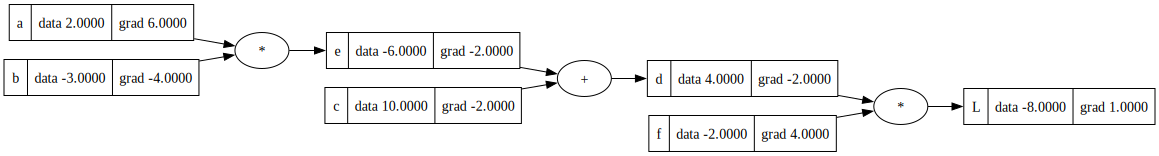

In [11]:
draw_dot(L)

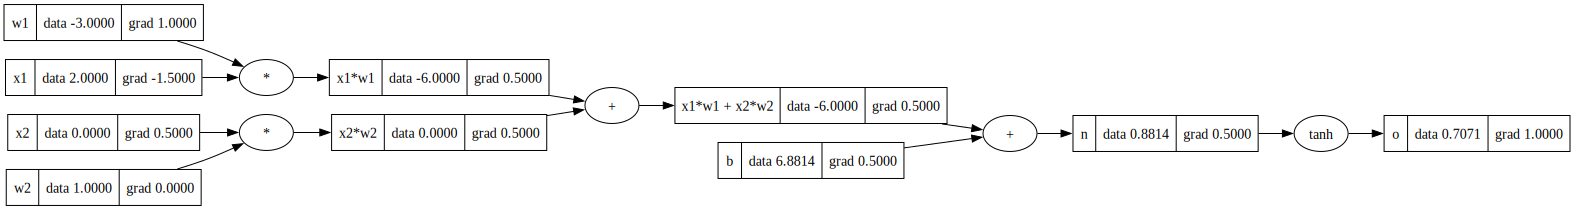

In [12]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.881375870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


o.backward()
draw_dot(o)

In [13]:
# figuring out the manual backpropagation
# d tanh/do
#  1- tanh(n)**2

# o.grad = 1.0
# n.grad = 1-(o.data**2)
# b.grad = 0.5
# x1w1x2w2.grad = 0.5
# x2w2.grad = 0.5
# x1w1.grad = 0.5
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

In [14]:
o.backward()

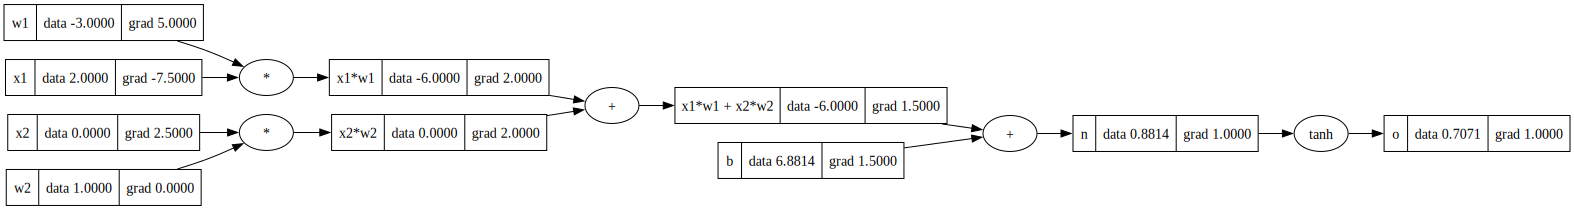

In [15]:
draw_dot(o)

In [16]:
## doing it via topological sort
o.grad = 1.0

topo=[]
visited=set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

In [17]:
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881375870195432),
 Value(data=0.8813758701954324),
 Value(data=0.7071079227726492)]

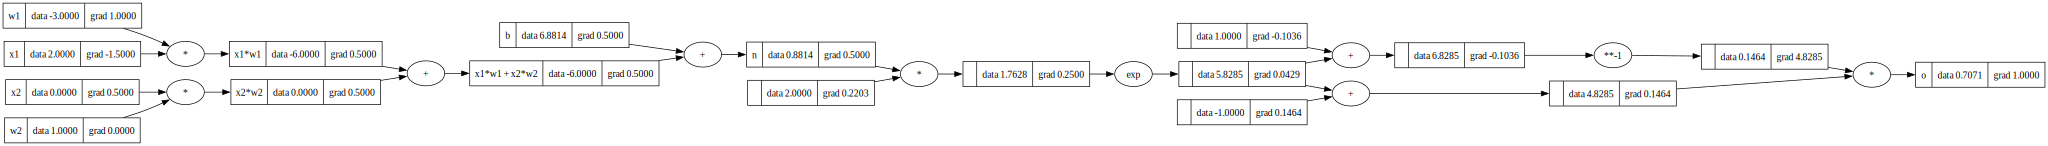

In [18]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.881375870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

# -------------------------
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
# -------------------------

o.backward()
draw_dot(o)

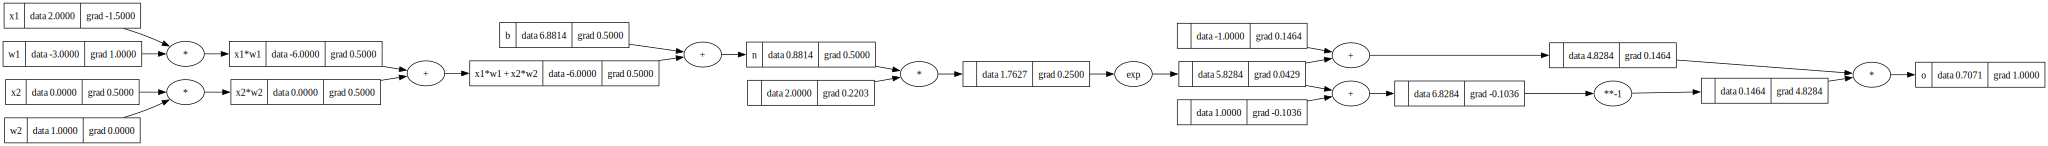

In [19]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [81]:
# class Neuron:
    
#     def __init__(self, nin):
#         self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
#         self.b = Value(random.uniform(-1,1))
        
#     def __call__(self, x):
#         act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
#         out = act.tanh()
#         return out
    
#     # def get_weights(self):
#     #     return [w.data for w in self.w]

#     # def get_bias(self):
#     #     return self.b.data
    
#     def parameters(self):
#         return self.w + [self.b]
    
    
# class Layer:
    
#     def __init__(self, nin, nout):
#         self.neurons = [Neuron(nin) for _ in range(nout)]
    
#     def __call__(self, x):
#         outs = [neuron(x) for neuron in self.neurons]
#         return outs[0] if len(outs) == 1 else outs
    
#     def get_weights_and_biases(self):
#         return [(n.get_weights(), n.get_bias()) for n in self.neurons]
    
#     def parameters(self):
#         return [p for neuron in self.neurons for p in neuron.parameters()]
    
# class MLP:
#     def __init__(self, nin, nouts):
#         sz = [nin] + nouts
#         # print(sz)
#         self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
#         # print(self.layers)
        
#     def __call__(self, x):
#         for layer in self.layers:
#             x = layer(x)
#         return x
    
#     def parameters(self):
#         return [p for layer in self.layers for p in layer.parameters()]

In [82]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [83]:
x = [2.0,3.0]
n = Layer(2,3)
n(x)

[Value(data=-0.9945150001264551),
 Value(data=-0.87474210877483),
 Value(data=-0.8533849867002745)]

In [84]:
layer = Layer(2, 3)
weights_and_biases = layer.get_weights_and_biases()

for i, (weights, bias) in enumerate(weights_and_biases, 1):
    print(f"Neuron {i}:")
    print(f"  Weights: {weights}")
    print(f"  Bias: {bias}")
    print()

AttributeError: 'Layer' object has no attribute 'get_weights_and_biases'

In [120]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.8331868665603823)

In [121]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8331868665603823),
 Value(data=0.7828211503155441),
 Value(data=0.8052070103954798),
 Value(data=0.7366248065387415)]

In [124]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt,yout in zip(ys,ypred)])
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #updating params
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.0679562162151495
1 0.06353804212646955
2 0.05961232438422037
3 0.056104136137467314
4 0.05295266645743107
5 0.05010809963792555
6 0.04752927723735648
7 0.0451819251813964
8 0.043037294261341646
9 0.04107110681749056
10 0.039262732800781894
11 0.03759453950123546
12 0.03605137406479461
13 0.03462014848012424
14 0.03328950432222378
15 0.032049540076648717
16 0.030891587940300377
17 0.029808030018278968
18 0.028792146101444198
19 0.027837986920704376


In [125]:
ypred

[Value(data=0.9454320901326335),
 Value(data=-0.9136791563511082),
 Value(data=-0.9022348010655027),
 Value(data=0.9113940861880366)]